### 1. State
LangGraph의 상태 관리를 의미  

주로 TypedDict나 Pydantic BaseModel을 사용하여 정의  

&emsp;- TypedDict는 dict와 달리 개발 타임 중에 미리 린트 오류가 남. 그래서 좀 더 안전하게 코드를 짤 수 있음

In [14]:
from typing import TypedDict, Annotated

class MyState(TypedDict):
    counter: Annotated[int, "counter"]

&emsp; - Pydantic의 BaseModel의 경우는 TypedDict보다도 데이터 무결성을 검증하는데 좋음  

&emsp; - 런타임 검사를 통해 ValidationError를 뿜고 멈추기도 하고 자동 변환(예: "123" 들어왔을 경우 int 타입이면 자동변환) 등의 기능이 있음

In [15]:
from pydantic import BaseModel, Field
from typing import Annotated

class GraphState(BaseModel):
    # 1. 리스트에 계속 추가(append)하고 싶을 때 (가장 많이 씀)
    messages: Annotated[list, "messages"]
    
    # 2. 정수 값을 누적해서 더하고 싶을 때 (operator.add 사용)
    step_count: Annotated[int, "step_count"] = Field(default=0)
    
    # 3. 덮어쓰기 (Annotated 없으면 기본적으로 덮어쓰기 됨)
    current_context: str = Field(default="")

&emsp; - Reducer 상태 업데이트를 활용하여 기본적으로는 덮어쓰기가 원칙이지만, 이를 활용하여 list에 append를 하거나, 커스텀 리듀서를 적용하여 값을 변경할 수 있음

In [16]:
## 리스트에 추가 하는 방법
import operator
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    messages: Annotated[list, add_messages] 
    history: Annotated[list, operator.add]

In [17]:
## 커스텀 리듀서 만드는 방법
def max_reducer(existing: int, new: int) -> int:
    return max(existing or 0, new or 0)

class ChatState(TypedDict):
    max_score: Annotated[int, max_reducer]
    current_score: Annotated[int, "current_score"]

---
### 2. Node
&emsp; - 실제 작업을 수행하는 기본 실행 단위를 말함  

&emsp; - State를 받아서 State를 반환하는 것이 기본  

&emsp; - 각각이 독립적이고 이를 조합하여 workflow를 만드는 것

In [18]:
from typing import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph

# 상태 정의
class State(TypedDict):
    context: Annotated[str, "context"]
    question: Annotated[str, "question"]
    answer: Annotated[str, "answer"]
    history: Annotated[list, add_messages]
    decision: Annotated[str, "decision"]

In [19]:
### Naive RAG 예시
def retrieve(state: State) -> State:
    question = state["question"]
    context = "retrieve 결과물"
    return State(context=context)

def generate(state: State) -> State:
    question = state["question"]
    context = state["context"]
    history = state["history"]
    
    answer = "question과 context를 바탕으로 한 결과물"
    return State(answer=answer)

In [20]:
## 그래프 생성 및 노드 추가
graph = StateGraph(State)

# 노드 추가
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)

---
### 3. Edge
&emsp; - Edge를 통해 이제 Node를 연결하고 이를 통해 WorkFlow를 완성할 수 있음  
1. Start 지정해서 워크 플로우 만들기

In [21]:
from langgraph.graph import START, END
# 위의 node들을 연결하여 그래프 출력해보기
graph.add_edge(START, "retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", END)

2. START 사용 안하고 워크플로우 만드는 방법

In [22]:
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", END)

&emsp; - 그래프 시각화

In [23]:
import random
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from dataclasses import dataclass


@dataclass
class NodeStyles:
    default: str = (
        "fill:#45C4B0, fill-opacity:0.3, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:bold, line-height:1.2"  # 기본 색상
    )
    first: str = (
        "fill:#45C4B0, fill-opacity:0.1, color:#23260F, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )
    last: str = (
        "fill:#45C4B0, fill-opacity:1, color:#000000, stroke:#45C4B0, stroke-width:1px, font-weight:normal, font-style:italic, stroke-dasharray:2,2"  # 점선 테두리
    )


def visualize_graph(graph, xray=False, ascii=False):
    """
    CompiledStateGraph 객체를 시각화하여 표시합니다.

    이 함수는 주어진 그래프 객체가 CompiledStateGraph 인스턴스인 경우
    해당 그래프를 Mermaid 형식의 PNG 이미지로 변환하여 표시합니다.

    Args:
        graph: 시각화할 그래프 객체. CompiledStateGraph 인스턴스여야 합니다.
        xray: 그래프 내부 상태를 표시할지 여부.
        ascii: ASCII 형식으로 그래프를 표시할지 여부.
    """

    if not ascii:
        try:
            # 그래프 시각화
            if isinstance(graph, CompiledStateGraph):
                display(
                    Image(
                        graph.get_graph(xray=xray).draw_mermaid_png(
                            background_color="white",
                            node_colors=NodeStyles(),
                        )
                    )
                )
        except Exception as e:
            print(f"그래프 시각화 실패 (추가 종속성 필요): {e}")
            print("ASCII로 그래프 표시:")
            try:
                print(graph.get_graph(xray=xray).draw_ascii())
            except Exception as ascii_error:
                print(f"ASCII 표시도 실패: {ascii_error}")
    else:
        print(graph.get_graph(xray=xray).draw_ascii())


def generate_random_hash():
    return f"{random.randint(0, 0xffffff):06x}"

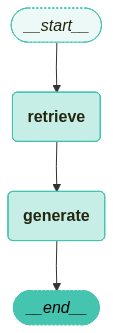

In [29]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = graph.compile(checkpointer=memory)
visualize_graph(app)

#### Command 와 Conditional Edge 비교표
| 특징 | conditional_edge (기존 방식) | Command (최신 방식) |
| :--- | :--- | :--- |
| **비유** | 🚦 **교차로 표지판** | 🛰️ **내비게이션 자동 경로 변경** |
| **역할** | 노드는 "일"만 하고,<br>길 찾기는 **"엣지"**가 담당 | 노드가 "일"도 하고,<br>**"다음 갈 곳"**도 직접 지정 |
| **구조** | 로직과 흐름의 **분리**<br>(Separation of Concerns) | 로직과 흐름의 **통합**<br>(Cohesion) |
| **장점** | 그래프 구조가 한눈에 보임<br>(시각화 유리, 정적) | State 업데이트와 이동을 한 번에 처리,<br>코드가 간결해짐 |
| **추천** | 단순한 **if / else 분기** | **Human-in-the-loop**,<br>동적 라우팅, 서브그래프 |


&emsp; - 조건부 엣지(Conditional Edge)라는 흐름 제어 메커니즘이 있고 이를 통해 동적으로 실행 경로를 결정할 수 있게 할 수 있음  

&emsp;&emsp; - 예시: 기본 naive에 이제 retrieve 이후에 이 context가 관련이 있는 것인지 체그하는 노드와 조건부 엣지 추가

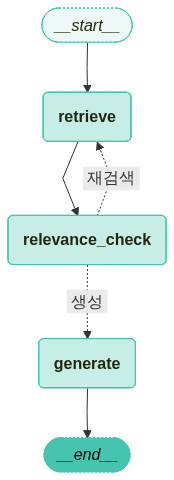

In [28]:
# 검증 노드 추가
def relevance_check(state: State) -> State:
    # Relevance Check: 관련성 확인
    decision = "생성"
    return GraphState(decision=decision)

# 조건부 엣지에 들어갈거
def decision(state: State) -> State:

    if state["binary_score"] == "yes":
        return "생성"
    else:
        return "재검색"
    
## 그래프 생성 및 노드 추가
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("relevance_check", relevance_check)
    


workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "relevance_check")
workflow.add_edge("generate", END)
    
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    decision,
    {
        "재검색": "retrieve",  # 관련성이 있으면 종료합니다.
        "생성": "generate",  # 관련성 체크 결과가 모호하다면 다시 답변을 생성합니다.
    },
)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
visualize_graph(app)

&emsp; - Command : conditional_edge 활용 말고 command 활용 방법  

&emsp;&emsp; - conditional_edge를 사용하게 되면 별도 node + conditional_edge로 구성이 되는데 이것을 Command 하나로 통합하는 느낌  

&emsp;&emsp; - 장점: Human in the Loop나 서브그래프, multi agent handoff 시에 장점이 생김

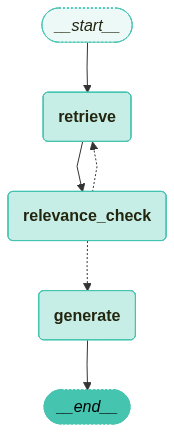

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.types import Command

# 1. 검증 및 라우팅을 동시에 하는 노드로 변경
def relevance_check(state: State) -> Command[Literal["generate", "retrieve"]]:
    # (여기서 실제로 LLM 등을 통해 점수를 계산했다고 가정합니다)
    # 예: score = chain.invoke(state) ...
    score = state.get("binary_score", "yes") 
    
    # decision 값 설정
    decision_result = "생성" if score == "yes" else "재검색"

    # [핵심 변경 사항]
    # 조건문(if)을 여기서 처리하고, Command로 다음 행선지(goto)를 바로 지시합니다.
    if score == "yes":
        return Command(
            update={"decision": decision_result}, # State 업데이트
            goto="generate"                       # 다음 노드 지정
        )
    else:
        return Command(
            update={"decision": decision_result}, # State 업데이트
            goto="retrieve"                       # 다음 노드 지정 (루프)
        )

# --- 그래프 정의 ---
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("relevance_check", relevance_check)

# 엣지 정의 (Conditional Edge가 사라짐!)
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "relevance_check") # retrieve 끝나면 무조건 check로
workflow.add_edge("generate", END)               # generate 끝나면 종료

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
visualize_graph(app)